## Final Project Submission

Please fill out:
* Student name: Devin Belden
* Student pace: full time
* Scheduled project review date/time: Wed, Jan 15, 2020, 2:00 PM - 3:00 PM MST
* Instructor name: James Irving, Ph.D
* Blog post URL: https://devinbelden.github.io/the_ocarina_of_time_series

# Business Case

For this project, we attempt to parse through real estate sales data throughout the US and nail down the five best ZIP codes in which to invest. The definition of "best" we have chosen for this project is to have a high return on investment (ROI) while having a narrow confidence band for that ROI. Additionally, we glance at which ZIP codes are least profitable in the short term (1 year), thereby giving a two-pronged approach to real estate investment. 

All of the predictions are made one year from the end of the Zillow dataset.

# Importing/Exploring Data

First, let's import relevant packages, as well as import the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-poster')
pd.set_option('display.max_columns', 0)

zillow = pd.read_csv('zillow_data.csv')

zillow.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,...,893000,895000,901200,909400,915000,916700,917700,919800,925800,937100,948200,951000,952500,958600,966200,970400,973900,974700,972600,974300,980800,988000,994700,998700,997000,993700,991300,989200,991300,999100,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,211100.0,205700.0,200900.0,196800.0,193600.0,191400.0,190400.0,190800.0,192700.0,196000.0,201300.0,207400.0,212200.0,214600.0,215100.0,213400.0,210200.0,206100.0,202100.0,198800.0,196100.0,194100.0,193400.0,...,251400,253000,255200,258000,261200,264700,268400,271400,273600,275200,276400,277000,277900,280000,282600,285400,288400,290800,292000,292800,293700,295200,297000,299000,300800,301800,302800,304400,306200,307000,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,195400.0,193000.0,191800.0,191800.0,193000.0,195200.0,198400.0,202800.0,208000.0,213800.0,220700.0,227500.0,231800.0,233400.0,233900.0,233500.0,233300.0,234300.0,237400.0,242800.0,250200.0,258600.0,268000.0,...,301700,302400,303600,306200,309100,311900,314100,316300,319000,322000,324300,326100,327300,327000,327200,328500,329800,330000,329000,327800,326700,325500,324700,324500,323700,322300,320700,320000,320000,320900,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,502200.0,500000.0,497900.0,496300.0,495200.0,494700.0,494900.0,496200.0,498600.0,502000.0,507600.0,514900.0,522200.0,529500.0,537900.0,546900.0,556400.0,566100.0,575600.0,584800.0,593500.0,601600.0,610100.0,...,1176400,1174600,1178500,1185700,1192900,1198800,1200400,1198900,1200200,1207400,1218600,1226600,1230700,1235400,1241300,1245700,1247000,1246700,1245700,1246000,1247700,1252900,1260900,1267900,1272600,1276600,1280300,1282500,1286000,1289000,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,77700.0,77800.0,77900.0,77900.0,77800.0,77800.0,77800.0,77800.0,77800.0,77900.0,78100.0,78200.0,78400.0,78600.0,78800.0,79000.0,79100.0,79200.0,79300.0,79300.0,79300.0,79400.0,79500.0,79500.0,79600.0,...,114700,115000,115000,115200,115600,115900,115600,115400,115400,115500,115800,116300,116200,115600,115000,114500,114200,114000,114000,113900,114100,114900,115700,116300,116900,117300,117600,118000,118600,118900,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


We'll need to convert this data such that it has a datetime index. We can do this using the `melt()` method built into pandas, as well as the `to_datetime()` and `set_index()` methods.

In [3]:
def melt_data(df): #formerly called it melt_data_student with REED
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [4]:
df = melt_data(zillow)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [5]:
df['Month'] = pd.to_datetime(df['Month'], errors='coerce')
df = df.set_index('Month', drop=False)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
Month,,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


It's worth mentioning that RegionID and RegionName seem to be two sides of the same coin, but in reality, RegionName is just the ZIP code. It's unknown what RegionID means, but we'll keep it in the dataframe anyway. It might come in handy later.

For RegionName, however, let's just rename that column ZipCode. 

In [6]:
df.rename(columns={'RegionName': 'ZipCode'}, inplace=True)

# EDA and Data Visualization

As part of EDA, we'll need to plot graphs of different ZIP codes' prices as functions of time. Let's create a new dataframe re-indexed by `ZipCode` and write a function to plot ZIP codes of our choice.

In [7]:
df2 = df.groupby('ZipCode').resample('MS').asfreq()
df2

RegionID  ZipCode  ...      Month MeanValue
ZipCode Month                          ...                     
1001    1996-04-01     58196     1001  ... 1996-04-01  113100.0
        1996-05-01     58196     1001  ... 1996-05-01  112800.0
        1996-06-01     58196     1001  ... 1996-06-01  112600.0
        1996-07-01     58196     1001  ... 1996-07-01  112300.0
        1996-08-01     58196     1001  ... 1996-08-01  112100.0
...                      ...      ...  ...        ...       ...
99901   2017-12-01    100478    99901  ... 2017-12-01  291900.0
        2018-01-01    100478    99901  ... 2018-01-01  294200.0
        2018-02-01    100478    99901  ... 2018-02-01  297500.0
        2018-03-01    100478    99901  ... 2018-03-01  302100.0
        2018-04-01    100478    99901  ... 2018-04-01  305100.0

[3744704 rows x 9 columns]

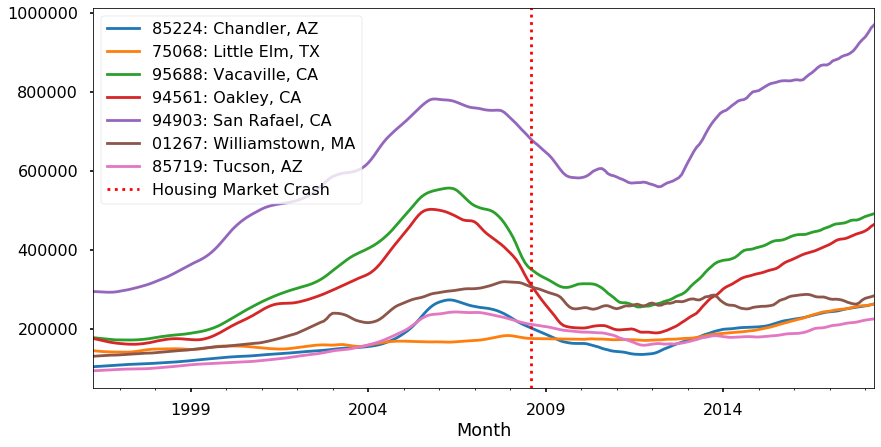

In [8]:
def plot_ts(zipcodes=[1001], df=df2, col='MeanValue', show_crash=False):
    
    fig, ax = plt.subplots(figsize=(14,7))
    
    for zipcode in zipcodes:
        ts = df[col].loc[zipcode]
        if zipcode/10000 < 1:
            label='0'+str(zipcode)+': '+df['City'][zipcode][0]+', '+df['State'][zipcode][0]
        else:
            label=str(zipcode)+': '+df['City'][zipcode][0]+', '+df['State'][zipcode][0]
        ts.plot(label=label, ax=ax)
        
    if show_crash:
        ax.axvline('08-2008', label='Housing Market Crash', color='red', ls=':')
    
    ax.legend()
    plt.show()

plot_ts(zipcodes=[85224,75068,95688,94561,94903,1267,85719], show_crash=True)

Just for laughs, let's look at a ZIP code in which I used to live, 85719.

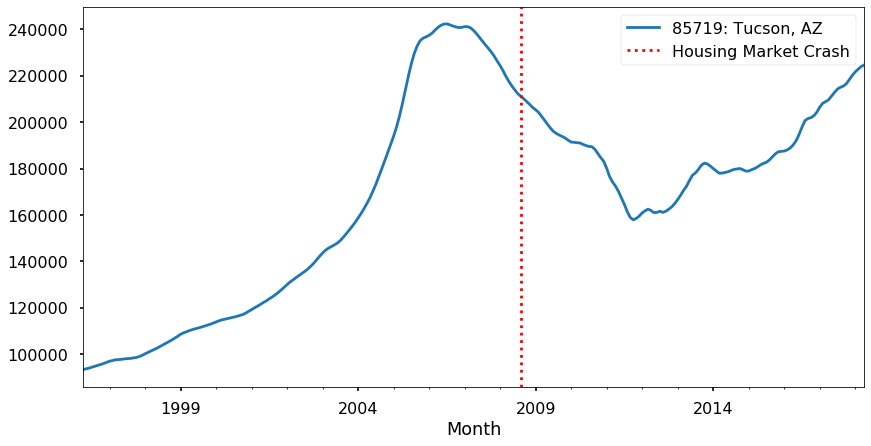

In [9]:
plot_ts([85719], show_crash=True)

For purposes of this project, we're going to move forward with data from 2010 onwards, as using pre-crash data would not only drastically increase our computing needs, but it's a reasonable assumption that it would also lead to somewhat unreliable predictions. However, we don't want to just use post-recovery data (2012 onwards), as the future predictions would be less conservative than we might want. Therefore, picking 2010 as our cutoff point is a decent combination of conservative estimation and computing power. 

In [10]:
df = df[df['Month'] > '2009-12-31']
df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
Month,,,,,,,,,
2010-01-01,84654,60657,Chicago,IL,Chicago,Cook,1,2010-01-01,775600.0
2010-01-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,2010-01-01,201300.0
2010-01-01,91982,77494,Katy,TX,Houston,Harris,3,2010-01-01,249200.0
2010-01-01,84616,60614,Chicago,IL,Chicago,Cook,4,2010-01-01,984100.0
2010-01-01,93144,79936,El Paso,TX,El Paso,El Paso,5,2010-01-01,117400.0


In [11]:
ts = df.loc[df['ZipCode'] == 85719]['MeanValue'].rename(85719)
ts.name

85719

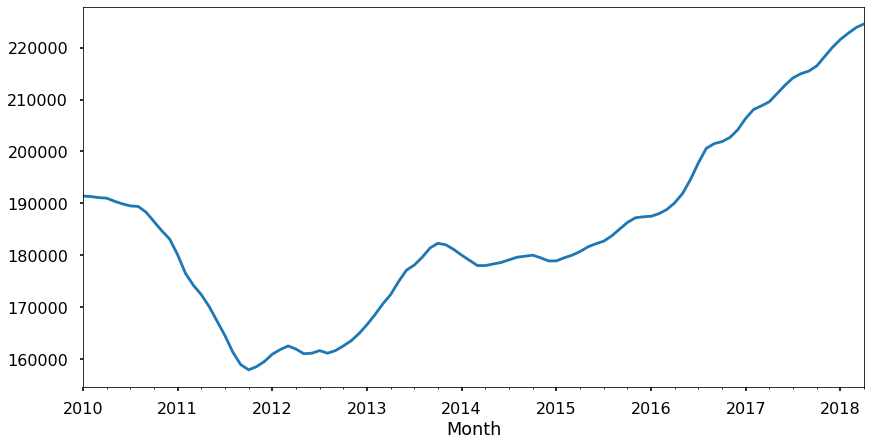

In [12]:
import pylab

plt.rcParams['figure.figsize'] = (14, 7)

ts = ts.resample('MS').asfreq()
ts.plot();

A significantly different graph. Let's check for missing values in our actionable dataframe.

In [13]:
df.isna().sum()

RegionID           0
ZipCode            0
City               0
State              0
Metro         102910
CountyName         0
SizeRank           0
Month              0
MeanValue          0
dtype: int64

In [14]:
df['Metro'].fillna('Missing',inplace=True)
df.isna().sum()

RegionID      0
ZipCode       0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
Month         0
MeanValue     0
dtype: int64

Excellent. Now let's see how much of our data we're cutting out, just in case it's a huge percentage.

In [15]:
print(df['ZipCode'].nunique())
zipcodes = list(df[df['Month'] == '2010-01-01']['ZipCode'].unique())
len(zipcodes)

14723


14144

We'll be left with 96% of unique ZIP codes, which is a large enough percentage that we can move forward.

In [16]:
for zipcode in df['ZipCode'].unique():
    if zipcode not in zipcodes:
        df = df[df['ZipCode'] != zipcode]
        
df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
Month,,,,,,,,,
2010-01-01,84654,60657,Chicago,IL,Chicago,Cook,1,2010-01-01,775600.0
2010-01-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,2010-01-01,201300.0
2010-01-01,91982,77494,Katy,TX,Houston,Harris,3,2010-01-01,249200.0
2010-01-01,84616,60614,Chicago,IL,Chicago,Cook,4,2010-01-01,984100.0
2010-01-01,93144,79936,El Paso,TX,El Paso,El Paso,5,2010-01-01,117400.0


As we've cut out all ZIP codes with fewer than 100 months' worth of data, we should have 100 months x 14,144 ZIP codes = 1,414,400 rows of data. 

In [17]:
len(df)

1414400

# ARIMA Modeling

Now we're ready for our ARIMA modeling, but first we have to choose which one. Do we run SARIMAX or ARIMA proper? To help us answer this question, we'll plot our ACF and PACF.

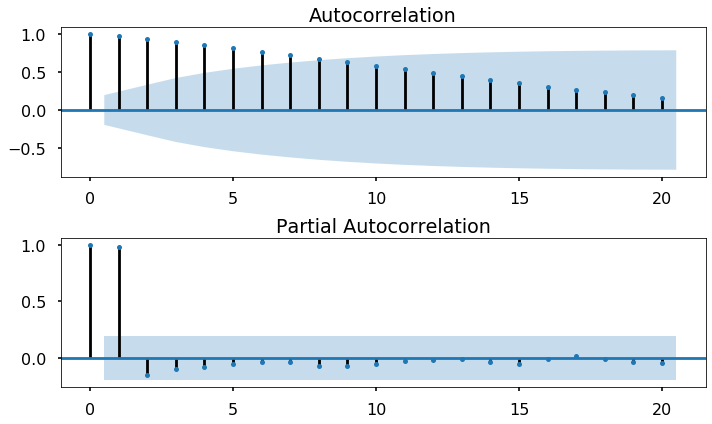

In [18]:
from  statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig,ax = plt.subplots(nrows=2,figsize=(10,6))

plot_acf(ts,ax=ax[0],lags=20);
plot_pacf(ts, ax=ax[1],lags=20);
plt.tight_layout()

If this were just AutoRegressive, the ACF would tail off, and PACF would cut off. If it were just a Moving Average, the ACF would cut off and the PACF would tail off. If it were ARMA, both ACF and PACF would tail off. Given those statements, this looks sort of like simply AutoRegressive, but let's do a seasonal decomposition just to check.

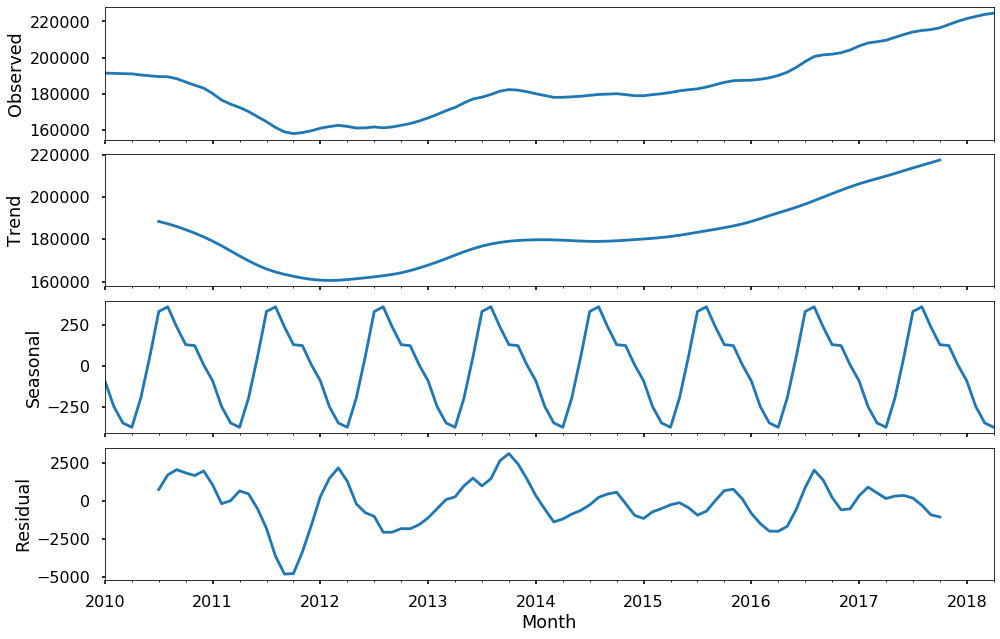

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

pylab.rcParams['figure.figsize'] = (14, 9)

seasonal_decompose(ts).plot();

Just as expected, the seasonal component is +/-250 dollars, whereas our data ranges from \\$160,000 to \\$220,000. To save on computing power, we'll run a regular ARIMA model, as the seasonal component makes such a miniscule difference that the tradeoff is not worth it.

For now, let's create an all-in-one function that will train/test split our data, run a grid search for the best `(p, d, q)` combination, create a prediction based on that data, plot a graph of the prediction, and show the diagnostics for the predicted model.

*A word of warning/notes to future me*: The next few functions get rather complicated, but a lot of them use the same processes. As part of the revision process, I'm going to clean them up and remove a lot of the redundancy between them.

In [20]:
def arima_tune(ts, test_size=0.12, plot=False, show_stats=False):
    import math
    import itertools
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    import warnings
    warnings.filterwarnings('ignore')
    
    ts_split = math.floor(len(ts.index) * (1-test_size))

    ts_train = ts.iloc[:ts_split]
    ts_test = ts.iloc[ts_split:]
    
    results = []
    combinations = list(itertools.product(range(6), [1], range(6)))
    for comb in combinations:
        try:
            model = SARIMAX(ts_train, order=comb, 
                            enforce_stationarity=False, 
                            enforce_invertibility=False)
            output = model.fit()
            results.append([comb, output.aic])
        except:
            print(f"Error running {comb}, continuing")
            continue
    
    df_results = pd.DataFrame(results, columns=['pdq', 'AIC'])
    best_pdq = df_results[df_results['AIC'] == df_results['AIC'].min()]['pdq']
    
    best_model = SARIMAX(ts_train, order=best_pdq.values[0],
                         enforce_stationarity=False, 
                         enforce_invertibility=True)
    best_output = best_model.fit()
    
    prediction = best_output.get_prediction(start=ts_test.index[0],
                                            end=ts_test.index[-1], 
                                            dynamic=True)
    
    df_pred = prediction.conf_int()
    df_pred['predicted_mean'] = prediction.predicted_mean
    predicted_roi = round(((df_pred['predicted_mean'][-1] - ts_train[-1])/ts_train[-1])*100, 2)
    
    if plot:
        df_plot = pd.concat([df_pred,ts_train], axis=1)
        
        fig, ax = plt.subplots(figsize=(13,8))
        ts_train.plot(ax=ax,label='Training Data')
        ts_test.plot(ax=ax,label='Test Data')
        df_pred['predicted_mean'].plot(ax=ax, label='Predicted', color='g')
        ax.fill_between(df_pred.index, df_pred[f'lower {ts.name}'],
                        df_pred[f'upper {ts.name}'], color="k", alpha=.15,
                        label = '95% Confidence Interval')
        ax.legend()
        ax.set(title=f"Predictions for {ts.name}")
        plt.show()
    
    score = 10 * predicted_roi / np.log(df_pred['predicted_mean'][-1] - 
                                        df_pred['predicted_mean'][0])
    
    if show_stats:
    
        print("Best PDQ combination:", best_pdq.values[0])
        print(f"Predicted ROI: {predicted_roi}%\nOverall Score: {round(score,2)}")
        display(best_output.summary())
        output.plot_diagnostics(figsize=(13,8))
        plt.tight_layout()

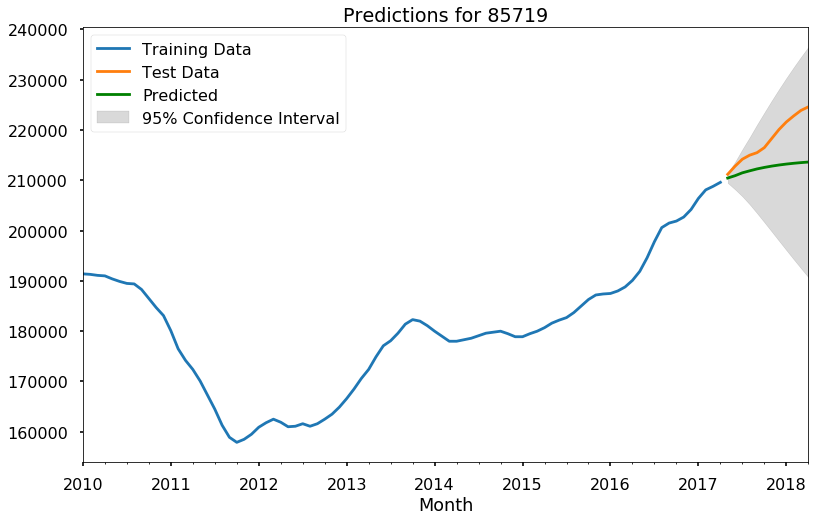

Best PDQ combination: (2, 1, 5)
Predicted ROI: 1.92%
Overall Score: 2.38


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  85719   No. Observations:                   88
Model:               SARIMAX(2, 1, 5)   Log Likelihood                -618.671
Date:                Wed, 15 Jan 2020   AIC                           1253.342
Time:                        11:36:02   BIC                           1272.497
Sample:                    01-01-2010   HQIC                          1261.027
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3822      0.137      2.781      0.005       0.113       0.652
ar.L2          0.3927      0.162      2.431      0.015       0.076       0.709
ma.L1          1.2454      2.879      0.433      0.665      -4.396       6.887
ma.L2          0.3146      1.850      0.170      0.865      -3.311       3.940
ma.L3         -0.1724      1.047     -0.165      0.869      -2.225       1.880
ma.L4          0.1352      0.685      0.197      0.844      -1.208       1.478
ma.L5         -0.0495      0.190     -0.260      0.795      -0.423       0.324
sigma2       2.41e+05    8.2e+05      0.294      0.769   -1.37e+06    1.85e+06
===================================================================================
Ljung-Box (Q):                       23.65   Jarque-Bera (JB):                 1.61
Prob(Q):                              0.98   Prob(JB):                         0.45
Heteroskedasticity (H):               0.62   Skew:                            -0.35
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

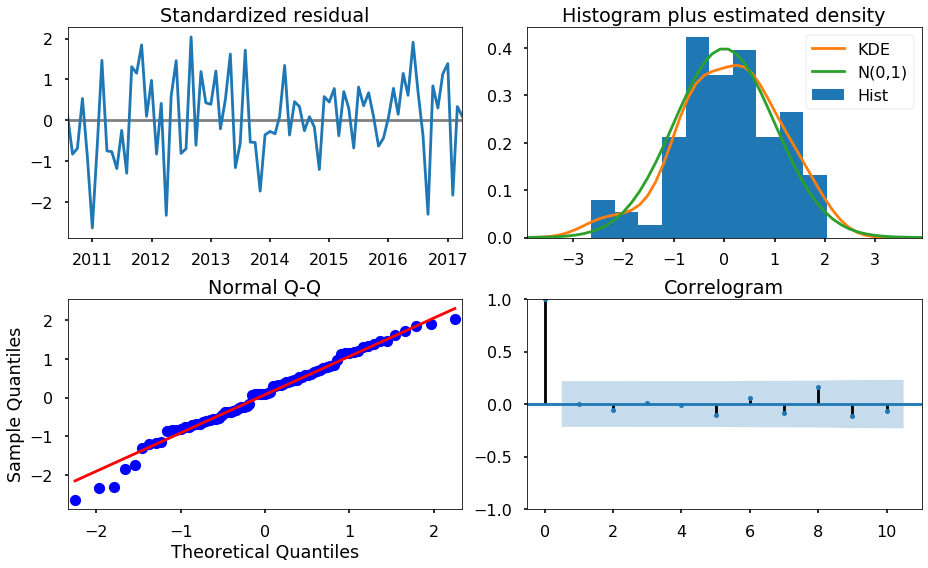

In [21]:
arima_tune(ts, plot=True, show_stats=True)

This worked for one ZIP code. Let's try five ZIP codes in a different metro, Miami-Fort Lauderdale.

In [22]:
df[df['Metro'] == 'Miami-Fort Lauderdale']['ZipCode'].nunique()

162

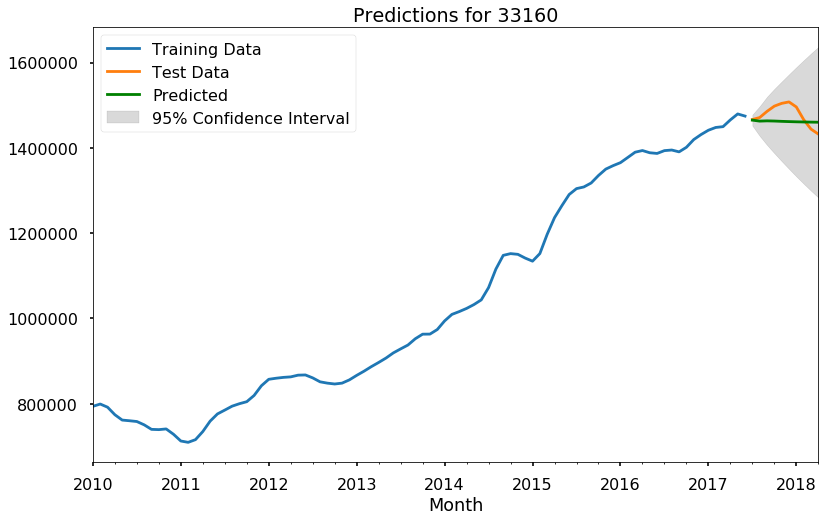

Best PDQ combination: (1, 1, 5)
Predicted ROI: -0.98%
Overall Score: nan


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  33160   No. Observations:                   90
Model:               SARIMAX(1, 1, 5)   Log Likelihood                -845.371
Date:                Wed, 15 Jan 2020   AIC                           1704.741
Time:                        11:38:45   BIC                           1721.673
Sample:                    01-01-2010   HQIC                          1711.544
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8241      0.133      6.202      0.000       0.564       1.085
ma.L1          0.6899      0.196      3.514      0.000       0.305       1.075
ma.L2         -0.3055      0.238     -1.283      0.200      -0.772       0.161
ma.L3         -0.3451      0.141     -2.448      0.014      -0.621      -0.069
ma.L4          0.0257      0.090      0.286      0.775      -0.150       0.202
ma.L5          0.0734      0.044      1.671      0.095      -0.013       0.160
sigma2       4.31e+07   1.86e-09   2.32e+16      0.000    4.31e+07    4.31e+07
===================================================================================
Ljung-Box (Q):                       44.96   Jarque-Bera (JB):                 2.81
Prob(Q):                              0.27   Prob(JB):                         0.25
Heteroskedasticity (H):               1.40   Skew:                             0.23
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.07e+32. Standard errors may be unstable.
"""

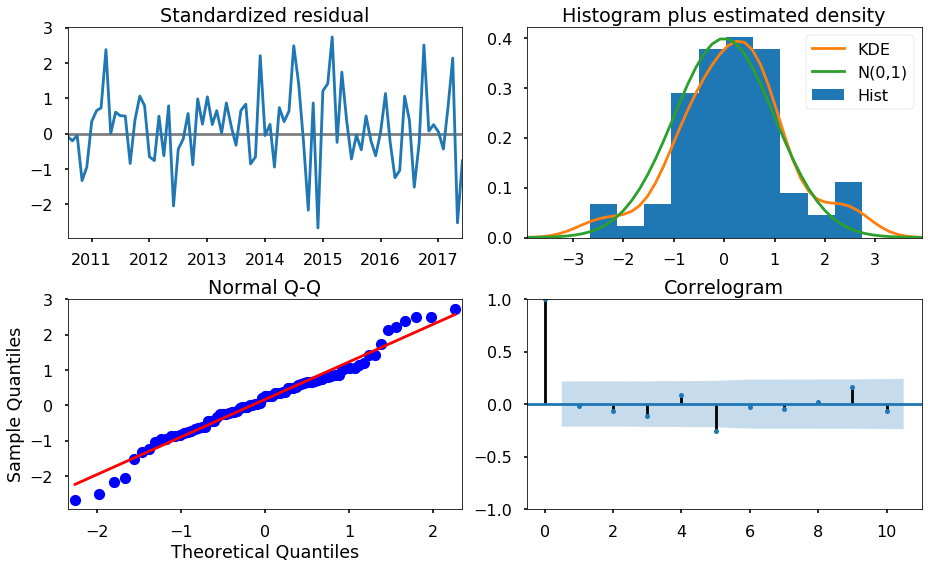

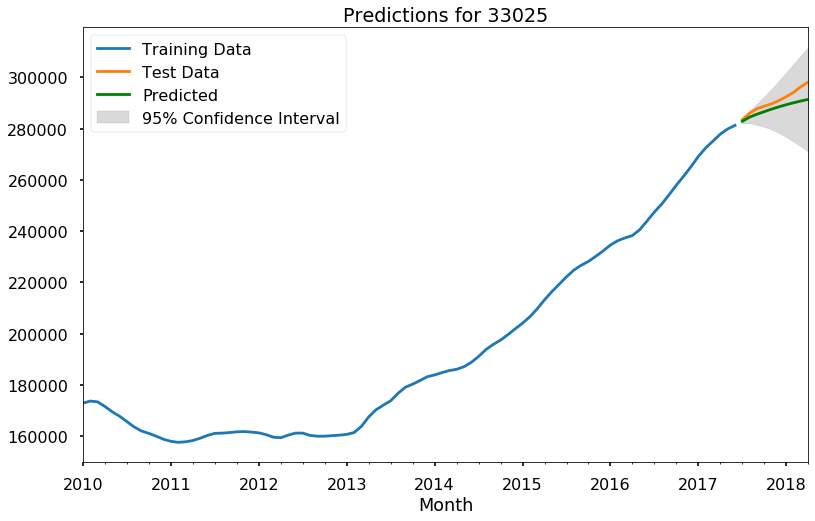

Best PDQ combination: (1, 1, 5)
Predicted ROI: 3.61%
Overall Score: 3.99


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  33025   No. Observations:                   90
Model:               SARIMAX(1, 1, 5)   Log Likelihood                -624.116
Date:                Wed, 15 Jan 2020   AIC                           1262.232
Time:                        11:38:50   BIC                           1279.164
Sample:                    01-01-2010   HQIC                          1269.035
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9161      0.061     15.072      0.000       0.797       1.035
ma.L1          0.8062      0.314      2.571      0.010       0.192       1.421
ma.L2         -0.1770      0.195     -0.907      0.364      -0.559       0.205
ma.L3         -0.3490      0.263     -1.327      0.185      -0.865       0.166
ma.L4          0.4572      0.192      2.382      0.017       0.081       0.833
ma.L5          0.1633      0.105      1.555      0.120      -0.043       0.369
sigma2      1.788e+05   6.47e+04      2.763      0.006     5.2e+04    3.06e+05
===================================================================================
Ljung-Box (Q):                       31.33   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.83   Prob(JB):                         0.90
Heteroskedasticity (H):               0.93   Skew:                            -0.02
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

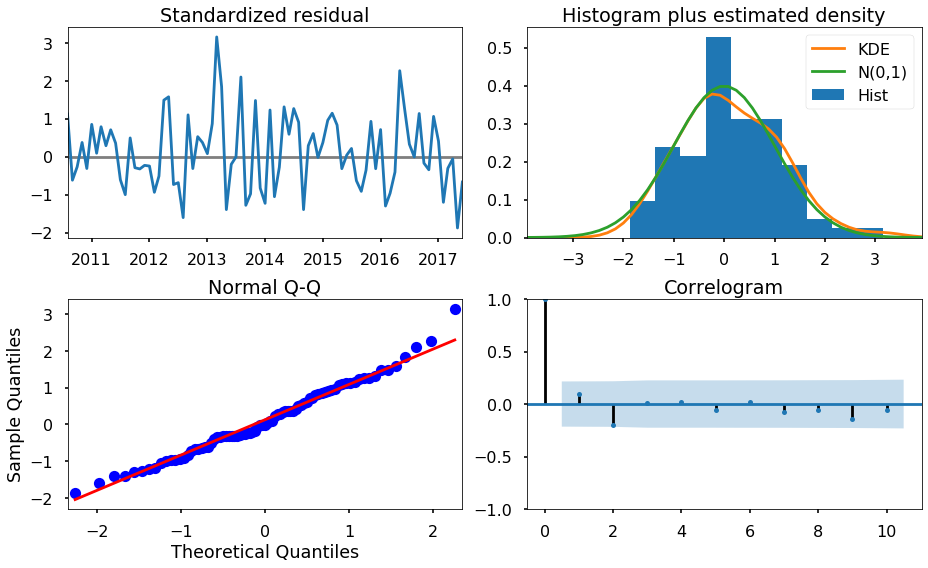

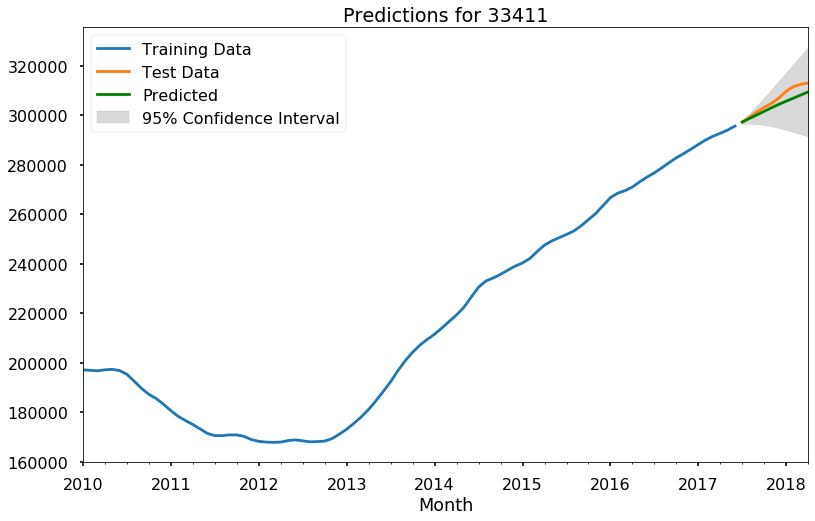

Best PDQ combination: (4, 1, 5)
Predicted ROI: 4.68%
Overall Score: 4.97


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  33411   No. Observations:                   90
Model:               SARIMAX(4, 1, 5)   Log Likelihood                -612.314
Date:                Wed, 15 Jan 2020   AIC                           1244.628
Time:                        11:38:54   BIC                           1268.817
Sample:                    01-01-2010   HQIC                          1254.346
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.0527      0.324      6.335      0.000       1.418       2.688
ar.L2         -2.1348      0.534     -3.998      0.000      -3.181      -1.088
ar.L3          1.4235      0.485      2.934      0.003       0.473       2.374
ar.L4         -0.3563      0.257     -1.386      0.166      -0.860       0.148
ma.L1         -0.4210      0.311     -1.354      0.176      -1.030       0.188
ma.L2          0.2443      0.181      1.353      0.176      -0.110       0.598
ma.L3          0.3494      0.184      1.903      0.057      -0.011       0.709
ma.L4         -0.1538      0.191     -0.804      0.422      -0.529       0.221
ma.L5         -0.2808      0.094     -2.993      0.003      -0.465      -0.097
sigma2       1.48e+05   2.81e+04      5.277      0.000     9.3e+04    2.03e+05
===================================================================================
Ljung-Box (Q):                       36.92   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.61   Prob(JB):                         0.80
Heteroskedasticity (H):               0.65   Skew:                            -0.14
Prob(H) (two-sided):                  0.26   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

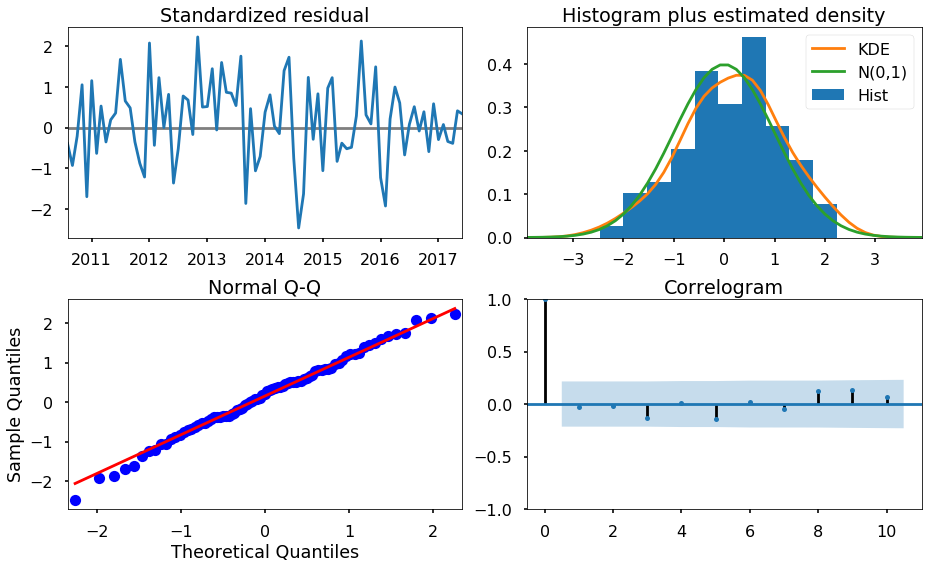

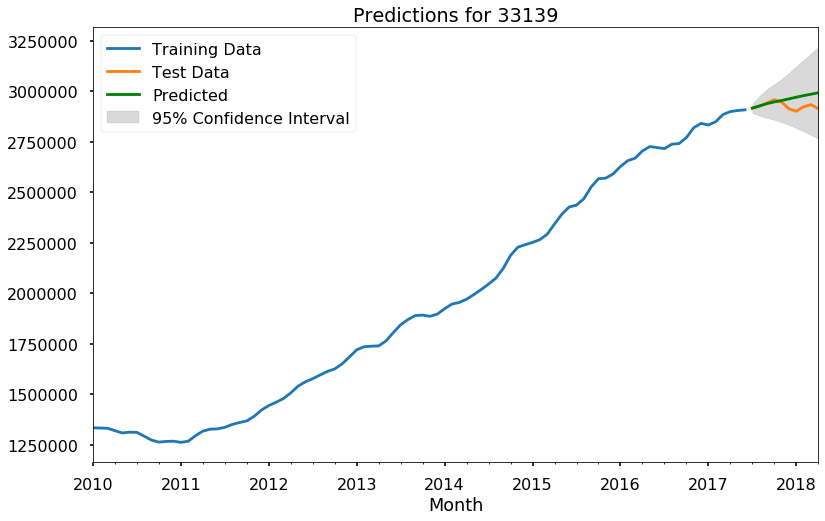

Best PDQ combination: (3, 1, 5)
Predicted ROI: 2.9%
Overall Score: 2.58


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  33139   No. Observations:                   90
Model:               SARIMAX(3, 1, 5)   Log Likelihood                -893.066
Date:                Wed, 15 Jan 2020   AIC                           1804.132
Time:                        11:38:59   BIC                           1825.901
Sample:                    01-01-2010   HQIC                          1812.877
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1651      0.329      3.542      0.000       0.520       1.810
ar.L2         -0.6372      0.455     -1.400      0.162      -1.529       0.255
ar.L3          0.4319      0.181      2.382      0.017       0.077       0.787
ma.L1         -0.1351      0.337     -0.401      0.688      -0.795       0.525
ma.L2         -0.2485      0.198     -1.253      0.210      -0.637       0.140
ma.L3         -0.1068      0.174     -0.615      0.539      -0.447       0.234
ma.L4          0.0823      0.063      1.310      0.190      -0.041       0.205
ma.L5          0.0206      0.086      0.240      0.810      -0.148       0.189
sigma2      1.252e+08   1.62e-09   7.73e+16      0.000    1.25e+08    1.25e+08
===================================================================================
Ljung-Box (Q):                       35.51   Jarque-Bera (JB):                 3.98
Prob(Q):                              0.67   Prob(JB):                         0.14
Heteroskedasticity (H):               4.21   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.27e+33. Standard errors may be unstable.
"""

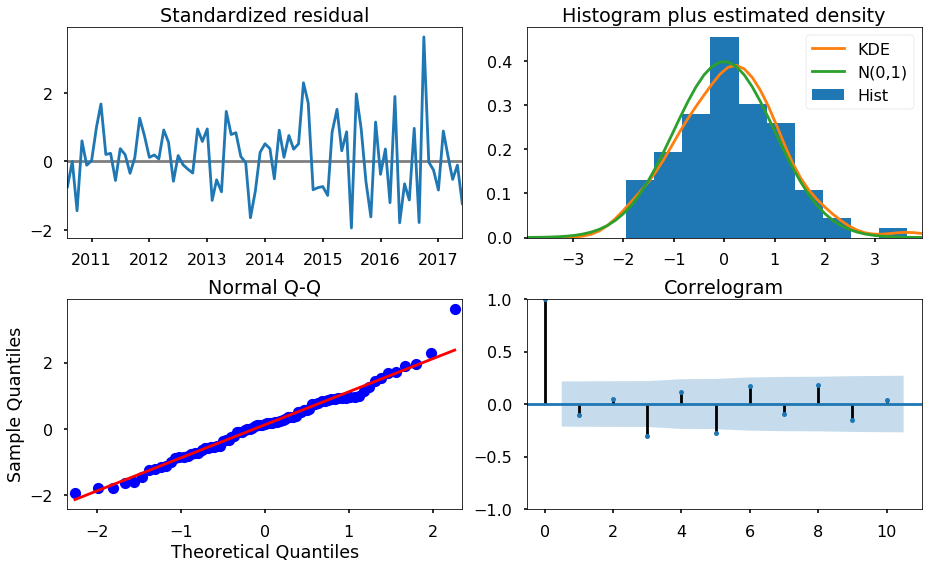

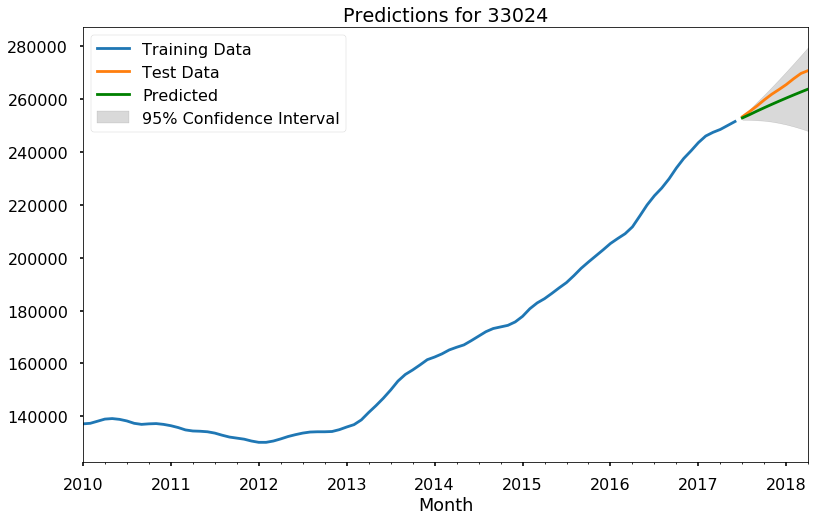

Best PDQ combination: (1, 1, 5)
Predicted ROI: 4.89%
Overall Score: 5.26


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  33024   No. Observations:                   90
Model:               SARIMAX(1, 1, 5)   Log Likelihood                -607.589
Date:                Wed, 15 Jan 2020   AIC                           1229.177
Time:                        11:39:03   BIC                           1246.109
Sample:                    01-01-2010   HQIC                          1235.979
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9767      0.030     32.657      0.000       0.918       1.035
ma.L1          0.7033      0.130      5.403      0.000       0.448       0.958
ma.L2         -0.3018      0.166     -1.816      0.069      -0.627       0.024
ma.L3         -0.3741      0.150     -2.494      0.013      -0.668      -0.080
ma.L4          0.1942      0.138      1.411      0.158      -0.076       0.464
ma.L5         -0.0430      0.121     -0.356      0.722      -0.280       0.194
sigma2      1.301e+05   1.78e+04      7.325      0.000    9.53e+04    1.65e+05
===================================================================================
Ljung-Box (Q):                       39.61   Jarque-Bera (JB):                 3.92
Prob(Q):                              0.49   Prob(JB):                         0.14
Heteroskedasticity (H):               3.56   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

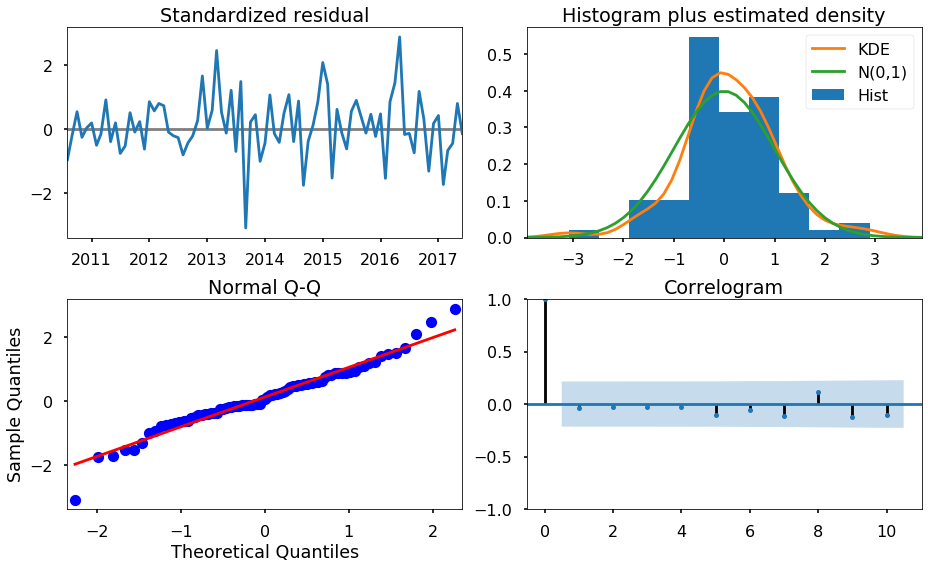

In [23]:
for zipcode in list(df[df['Metro'] == 'Miami-Fort Lauderdale']['ZipCode'].unique()[:5]):
    ts_ = df[df['ZipCode'] == zipcode]['MeanValue'].rename(zipcode)
    ts_ = ts_.resample('MS').asfreq()
    arima_tune(ts_, test_size=0.1, plot=True, show_stats=True)

It's worth noting that the above cell took over 45 seconds to run 5 ZIP codes. In order to run all 14,144 ZIP codes, it would take over 35 hours! We should try to parse our data further, such that we're only looking at a subset of ZIP codes. 

For this task, we'll be looking at [this article](https://www.businessinsider.com/best-places-to-invest-in-real-estate-in-the-us-2019-7), which gives ten metro areas that Zillow predicts to have the highest growth. 

In [24]:
metros = {'Tampa': 'FL','Las Vegas': 'NV','Phoenix': 'AZ','Atlanta': 'GA','Orlando': 'FL','Miami-Fort Lauderdale': 'FL',
          'Detroit': 'MI','Dallas-Fort Worth': 'TX','Nashville': 'TN','Charlotte': 'NC'}
total_length = 0
for key in metros:
    total_length += len(df[(df['Metro'] == key) & (df['State'] == metros[key])])

# return total_length divided by 100 months per ZIP code to get total number of ZIP codes

total_length/100

1208.0

Great! We've clipped our dataset from 14,144 ZIP codes down to 1,208. This should take a much more manageable 3 hours to run analysis on what's left. 

Next, we'll create another, more specialized function that will return the predicted ROI as well as a "score" of sorts. The score will be defined as the ROI divided by the log of the range of prices contained within the 95% confidence interval, times 10. This will give a score, I predict, between -15 and +40, which will hopefully be a simple enough number to give to a real estate investor looking for fast, easily-accessible information on which to base their investment decisions. The idea behind this definition is to give higher priority to ZIP codes that have a high predicted ROI, but penalize those areas where the 95% confidence interval is wide. Thus, the best ZIP codes in which to invest will have a combination of high ROI and low volatility.

After producing this score, we will create a dataframe ranking the ZIP codes from highest score to lowest score.

In [25]:
def forecast_score(ts, test_size):
    import math
    import itertools
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    import warnings
    warnings.filterwarnings('ignore')
    
    ts_split = math.floor(len(ts.index) * (1-test_size))

    ts_train = ts.iloc[:ts_split]
    ts_test = ts.iloc[ts_split:]
    
    results = []
    combinations = list(itertools.product(range(6), [1], range(6)))
    for comb in combinations:
        try:
            model = SARIMAX(ts_train, order=comb, 
                            enforce_stationarity=False, 
                            enforce_invertibility=False)
            output = model.fit()
            results.append([comb, output.aic])
        except:
            continue
    
    df_results = pd.DataFrame(results, columns=['pdq', 'AIC'])
    best_pdq = df_results[df_results['AIC'] == df_results['AIC'].min()]['pdq']
    
    model = SARIMAX(ts, order=best_pdq.values[0],
                         enforce_stationarity=False, 
                         enforce_invertibility=True)
    model_fit = model.fit()
    
    prediction = model_fit.get_prediction(start=ts.index[-1], 
                                          end=ts.index.shift(12)[-1], 
                                          dynamic=True)
    
    df_pred = prediction.conf_int()
    df_pred['predicted_mean'] = prediction.predicted_mean
    roi = round(((df_pred['predicted_mean'][-1] - ts_test[-1])/ts_test[-1])*100, 2)
    denom = np.log(df_pred[f"upper {ts.name}"][-1] - df_pred[f"upper {ts.name}"][0])
    score = 10 * roi / denom
    
    return roi, score

Testing this on two ZIP codes, just to make sure the data is return in the form we want, which is a list of lists:

In [26]:
list_roi_score = []
for zipcode in list(df[(df['Metro'] == 'Charlotte') & (df['State'] == 'NC')]['ZipCode'].unique())[:2]:
    ts_ = df[df['ZipCode'] == zipcode]['MeanValue'].rename(zipcode)
    ts_ = ts_.resample('MS').asfreq()

    list_roi_score.append([zipcode, 
                           forecast_score(ts_, test_size=0.1)[0], 
                           forecast_score(ts_, test_size=0.1)[1]])

list_roi_score

[[28269, 10.94, 10.593733670754231], [28277, 5.15, 4.895246702463379]]

Perfect! Now we're ready to run our function on every ZIP code in every metro area we've selected. 

In [24]:
#DO NOT RUN THIS CODE IF YOU DON'T WANT TO WAIT FOR 3 HOURS, KEEP SCROLLING FOR THE PICKLE FILE FURTHER DOWN

metros = {'Tampa': 'FL','Las Vegas': 'NV','Phoenix': 'AZ','Atlanta': 'GA','Orlando': 'FL','Miami-Fort Lauderdale': 'FL',
          'Detroit': 'MI','Dallas-Fort Worth': 'TX','Nashville': 'TN','Charlotte': 'NC'}

list_roi_score = []

for city in metros:
    for zipcode in list(df[(df['Metro'] == city) & (df['State'] == metros[city])]['ZipCode'].unique()):
        ts_ = df[df['ZipCode'] == zipcode]['MeanValue'].rename(zipcode)
        ts_ = ts_.resample('MS').asfreq()

        list_roi_score.append([city,
                               zipcode, 
                               forecast_score(ts_, test_size=0.1)[0], 
                               forecast_score(ts_, test_size=0.1)[1]])


In [27]:
list_roi_score

[['Tampa', 33510, 7.53, 7.168576238971737],
 ['Tampa', 33511, 5.22, 5.068985282684401],
 ['Tampa', 33523, 15.79, 15.343969766426692],
 ['Tampa', 33525, 10.66, 10.156663585309824],
 ['Tampa', 33527, 12.42, 11.38032896835194],
 ['Tampa', 33534, 4.07, 3.998651824145696],
 ['Tampa', 33540, 0.86, 0.8685958610226435],
 ['Tampa', 33541, 2.13, 2.1247013271872466],
 ['Tampa', 33542, 1.37, 1.3719154466836658],
 ['Tampa', 33543, 4.26, 4.109858598804386],
 ['Tampa', 33544, 4.18, 4.008299975504232],
 ['Tampa', 33545, 2.67, 2.606938391246499],
 ['Tampa', 33547, 0.38, 0.3857477112616072],
 ['Tampa', 33548, 0.47, 0.46639415668923023],
 ['Tampa', 33549, 6.5, 6.124682459446107],
 ['Tampa', 33556, 2.85, 2.70672357727771],
 ['Tampa', 33558, 3.72, 3.509550961861577],
 ['Tampa', 33559, 7.7, 7.451228525425187],
 ['Tampa', 33563, 3.29, 3.2735946324933773],
 ['Tampa', 33565, 5.5, 5.075827290298872],
 ['Tampa', 33566, 5.13, 5.031015653661826],
 ['Tampa', 33567, 7.78, 7.381553951105615],
 ['Tampa', 33569, 4.68, 

We'll save this as a pickle file to recall for future reads of this notebook.

In [38]:
df_roi_score = pd.DataFrame(list_roi_score, columns=['City','Zip','ROI','Score'])

import pickle
df_roi_score.to_pickle('df_roi_score.pickle')

In [2]:
import pickle
df_exp = pd.read_pickle('df_roi_score.pickle')
df_exp.head()

,City,Zip,ROI,Score
0,Tampa,33510,7.53,7.168576
1,Tampa,33511,5.22,5.068985
2,Tampa,33523,15.79,15.343970
3,Tampa,33525,10.66,10.156664
4,Tampa,33527,12.42,11.380329


Great! Now all that's left is to sort by 'Score', and grab the first 5-10 ZIP codes. 

In [3]:
df_exp.sort_values('Score', ascending=False).head(10)

,City,Zip,ROI,Score
1014,Dallas-Fort Worth,76114,35.18,32.019052
99,Tampa,34652,33.57,30.868488
114,Tampa,34691,32.85,30.544456
1085,Nashville,37085,33.58,28.667400
1185,Charlotte,28208,30.38,28.336297
965,Dallas-Fort Worth,76009,29.39,26.520774
113,Tampa,34690,26.22,24.912608
922,Dallas-Fort Worth,75217,25.25,24.097867
934,Dallas-Fort Worth,75233,26.82,23.745321
900,Dallas-Fort Worth,75141,24.69,22.846178


And just for laughs, let's grab the bottom 30 as well.

In [35]:
df_exp.sort_values('Score').head(30)

,City,Zip,ROI,Score
582,Miami-Fort Lauderdale,33149,-9.43,-10.068471
437,Atlanta,30625,-5.73,-5.968296
576,Miami-Fort Lauderdale,33140,-4.77,-4.162041
936,Dallas-Fort Worth,75235,-3.21,-3.199126
672,Miami-Fort Lauderdale,33449,-2.74,-2.701288
834,Detroit,48455,-2.10,-2.160402
454,Orlando,32714,-2.09,-2.110707
736,Detroit,48089,-1.67,-1.824186
831,Detroit,48428,-1.72,-1.778685
1104,Nashville,37149,-1.78,-1.722201


In [30]:
df_exp[df_exp['City'] == 'Las Vegas'].sort_values('Score').head()

,City,Zip,ROI,Score
125,Las Vegas,89029,0.83,0.848525
152,Las Vegas,89124,2.81,2.587013
143,Las Vegas,89113,4.86,4.564491
130,Las Vegas,89044,5.25,4.854569
172,Las Vegas,89166,6.25,5.841655


In [31]:
df_exp[df_exp['City'] == 'Tampa'].sort_values('Score').head()

,City,Zip,ROI,Score
65,Tampa,33716,0.38,0.353195
12,Tampa,33547,0.38,0.385748
13,Tampa,33548,0.47,0.466394
24,Tampa,33572,0.53,0.527817
34,Tampa,33598,0.55,0.543394


Interesting to see that the only two cities in our dataset to have all positive scores are Las Vegas and Tampa. 

# Prediction Testing

Let's see how our predictions did on the top five ZIP codes, by comparing them to the observed test data.

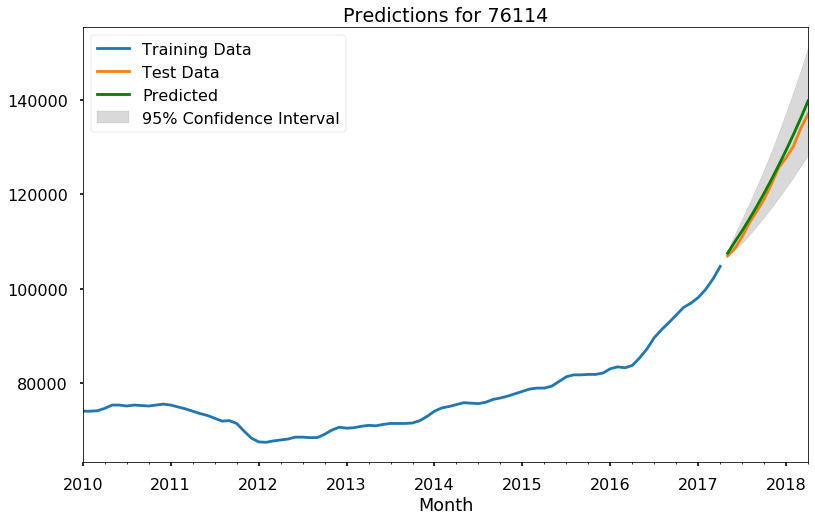

Best PDQ combination: (1, 1, 5)
Predicted ROI: 33.52%
Overall Score: 32.28


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  76114   No. Observations:                   88
Model:               SARIMAX(1, 1, 5)   Log Likelihood                -584.910
Date:                Wed, 15 Jan 2020   AIC                           1183.820
Time:                        11:55:40   BIC                           1200.581
Sample:                    01-01-2010   HQIC                          1190.545
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0457      0.026     39.640      0.000       0.994       1.097
ma.L1          0.2907      0.123      2.371      0.018       0.050       0.531
ma.L2         -0.6006      0.121     -4.973      0.000      -0.837      -0.364
ma.L3         -0.5238      0.116     -4.513      0.000      -0.751      -0.296
ma.L4          0.1576      0.105      1.499      0.134      -0.048       0.363
ma.L5          0.0063      0.102      0.062      0.951      -0.194       0.207
sigma2       1.06e+05   1.73e+04      6.113      0.000     7.2e+04     1.4e+05
===================================================================================
Ljung-Box (Q):                       24.56   Jarque-Bera (JB):                 0.23
Prob(Q):                              0.97   Prob(JB):                         0.89
Heteroskedasticity (H):               1.10   Skew:                            -0.05
Prob(H) (two-sided):                  0.80   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

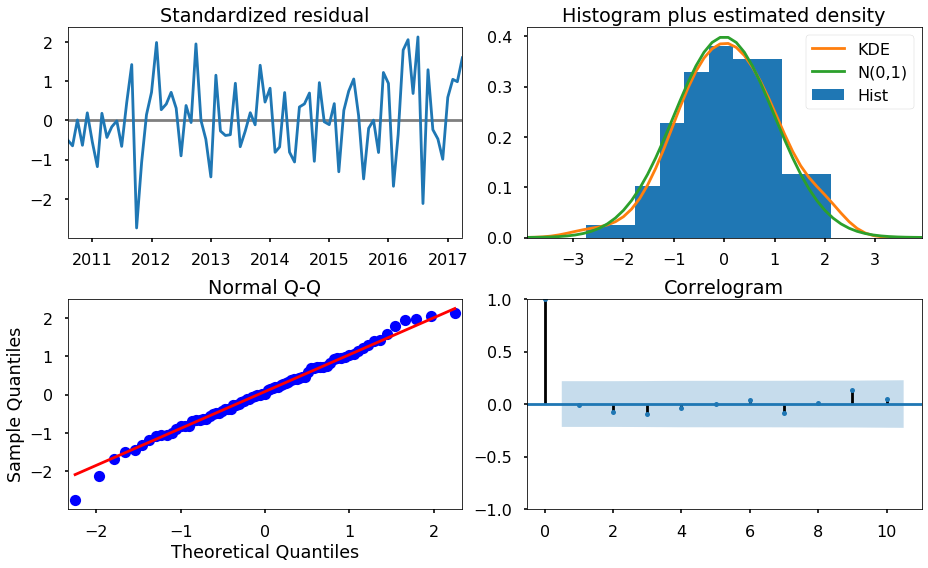

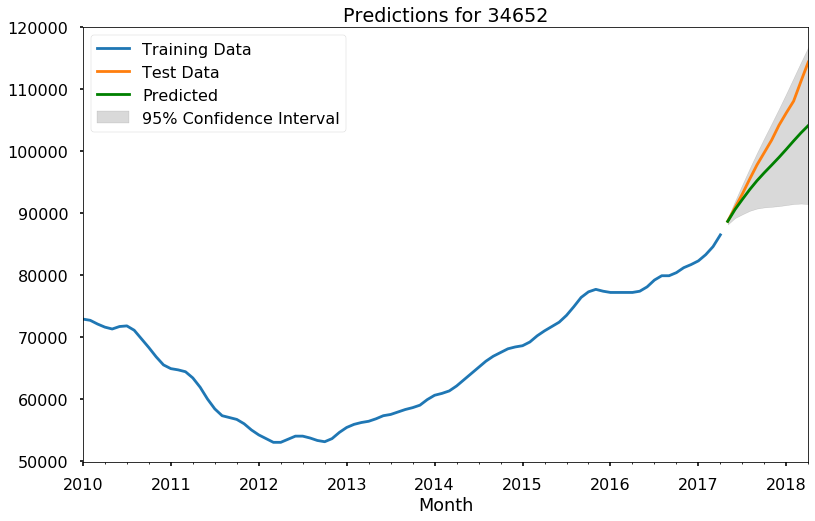

Best PDQ combination: (3, 1, 5)
Predicted ROI: 20.41%
Overall Score: 21.16


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  34652   No. Observations:                   88
Model:               SARIMAX(3, 1, 5)   Log Likelihood                -562.955
Date:                Wed, 15 Jan 2020   AIC                           1143.910
Time:                        11:55:44   BIC                           1165.460
Sample:                    01-01-2010   HQIC                          1152.556
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.1708      0.079     27.594      0.000       2.017       2.325
ar.L2         -2.0993      0.111    -18.840      0.000      -2.318      -1.881
ar.L3          0.9085      0.075     12.076      0.000       0.761       1.056
ma.L1         -0.6178      0.207     -2.980      0.003      -1.024      -0.211
ma.L2          0.1036      0.247      0.419      0.675      -0.381       0.588
ma.L3          0.2999      0.265      1.133      0.257      -0.219       0.819
ma.L4          0.4039      0.157      2.565      0.010       0.095       0.712
ma.L5         -0.4778      0.207     -2.306      0.021      -0.884      -0.072
sigma2      6.501e+04   2.06e+04      3.159      0.002    2.47e+04    1.05e+05
===================================================================================
Ljung-Box (Q):                       36.89   Jarque-Bera (JB):                 1.16
Prob(Q):                              0.61   Prob(JB):                         0.56
Heteroskedasticity (H):               2.44   Skew:                             0.29
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

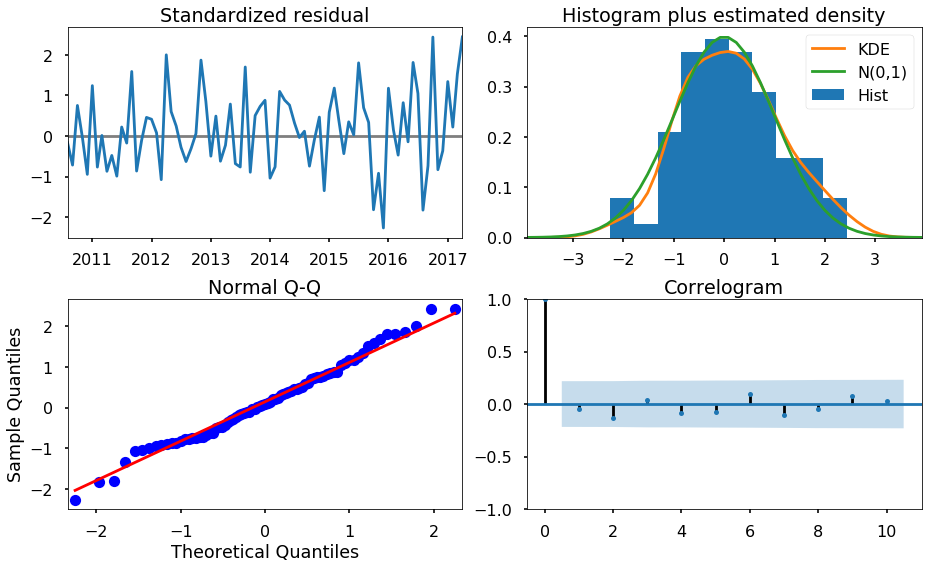

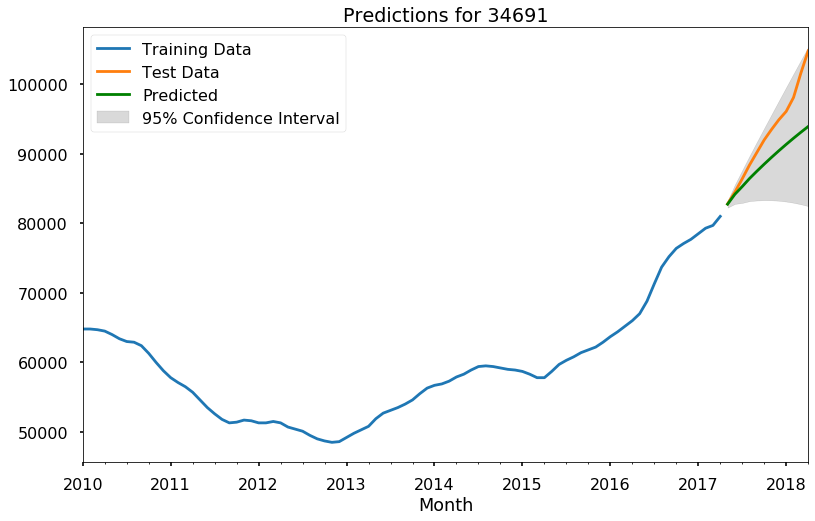

Best PDQ combination: (1, 1, 5)
Predicted ROI: 15.96%
Overall Score: 17.12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  34691   No. Observations:                   88
Model:               SARIMAX(1, 1, 5)   Log Likelihood                -565.630
Date:                Wed, 15 Jan 2020   AIC                           1145.260
Time:                        11:55:49   BIC                           1162.021
Sample:                    01-01-2010   HQIC                          1151.985
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9668      0.061     15.933      0.000       0.848       1.086
ma.L1          0.6513      0.135      4.824      0.000       0.387       0.916
ma.L2         -0.3563      0.141     -2.522      0.012      -0.633      -0.079
ma.L3         -0.4412      0.161     -2.744      0.006      -0.756      -0.126
ma.L4          0.1400      0.181      0.774      0.439      -0.215       0.495
ma.L5         -0.1135      0.114     -0.998      0.318      -0.336       0.109
sigma2      6.387e+04   1.01e+04      6.322      0.000    4.41e+04    8.37e+04
===================================================================================
Ljung-Box (Q):                       26.98   Jarque-Bera (JB):                 0.92
Prob(Q):                              0.94   Prob(JB):                         0.63
Heteroskedasticity (H):               2.51   Skew:                             0.08
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

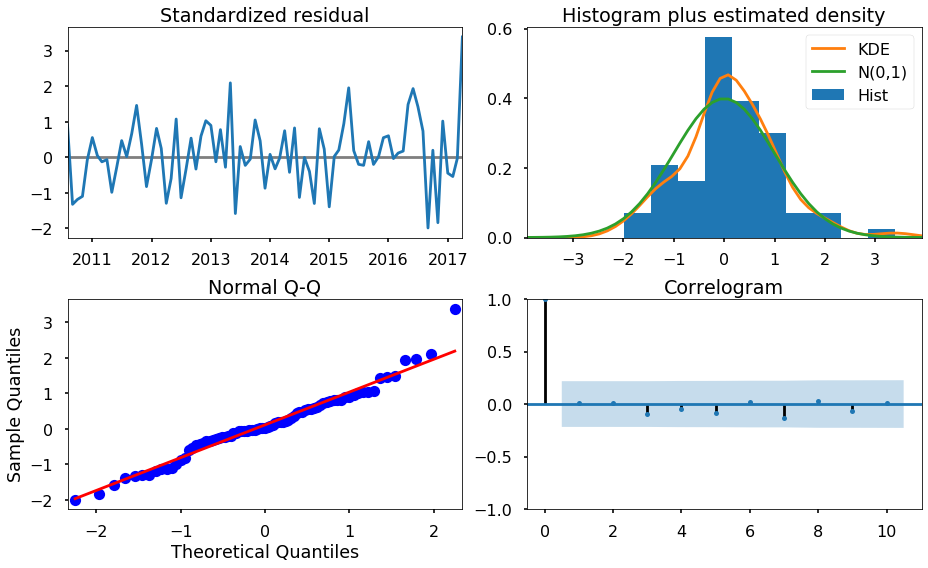

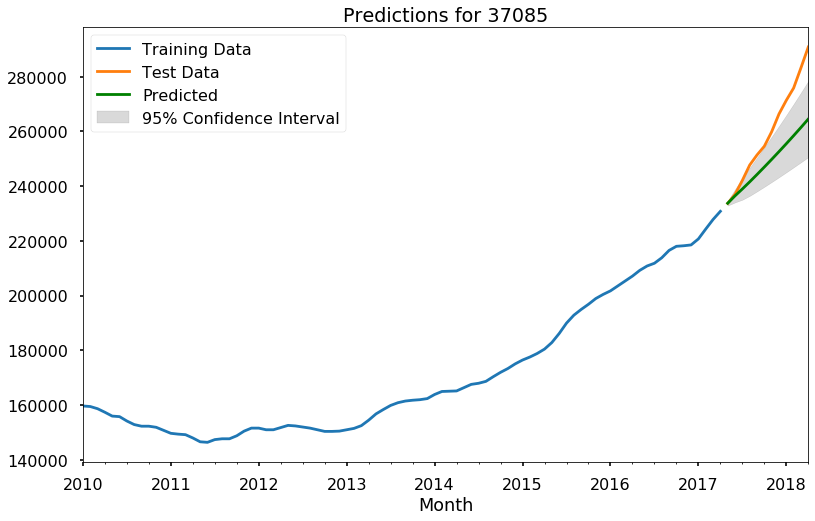

Best PDQ combination: (1, 1, 5)
Predicted ROI: 14.62%
Overall Score: 14.15


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  37085   No. Observations:                   88
Model:               SARIMAX(1, 1, 5)   Log Likelihood                -608.300
Date:                Wed, 15 Jan 2020   AIC                           1230.599
Time:                        11:55:55   BIC                           1247.360
Sample:                    01-01-2010   HQIC                          1237.324
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0187      0.014     70.835      0.000       0.991       1.047
ma.L1          0.6175      0.097      6.371      0.000       0.428       0.808
ma.L2         -0.6403      0.121     -5.275      0.000      -0.878      -0.402
ma.L3         -0.8588      0.106     -8.095      0.000      -1.067      -0.651
ma.L4          0.0252      0.126      0.199      0.842      -0.223       0.273
ma.L5          0.1247      0.063      1.968      0.049       0.000       0.249
sigma2      1.885e+05   3.54e+04      5.320      0.000    1.19e+05    2.58e+05
===================================================================================
Ljung-Box (Q):                       27.58   Jarque-Bera (JB):                 1.37
Prob(Q):                              0.93   Prob(JB):                         0.50
Heteroskedasticity (H):               1.18   Skew:                             0.04
Prob(H) (two-sided):                  0.67   Kurtosis:                         2.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

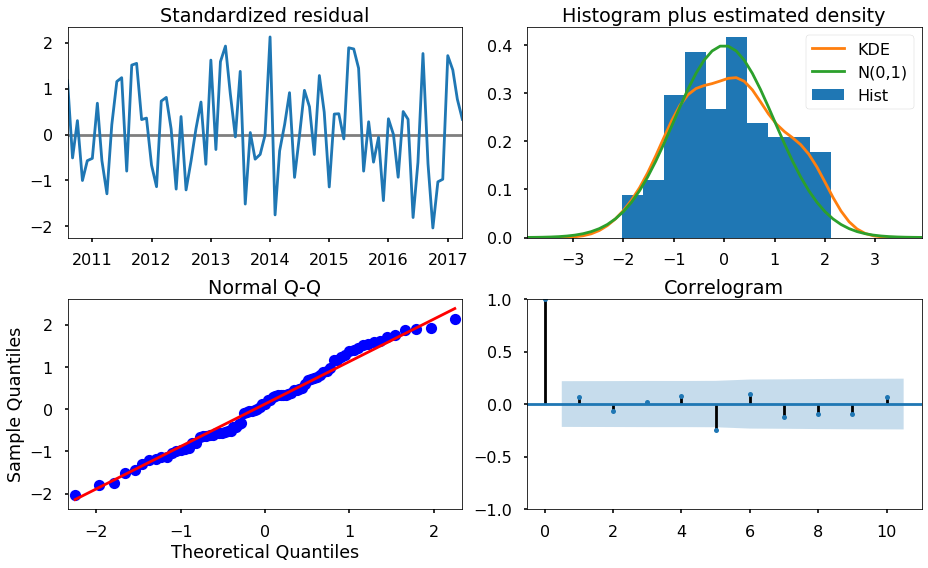

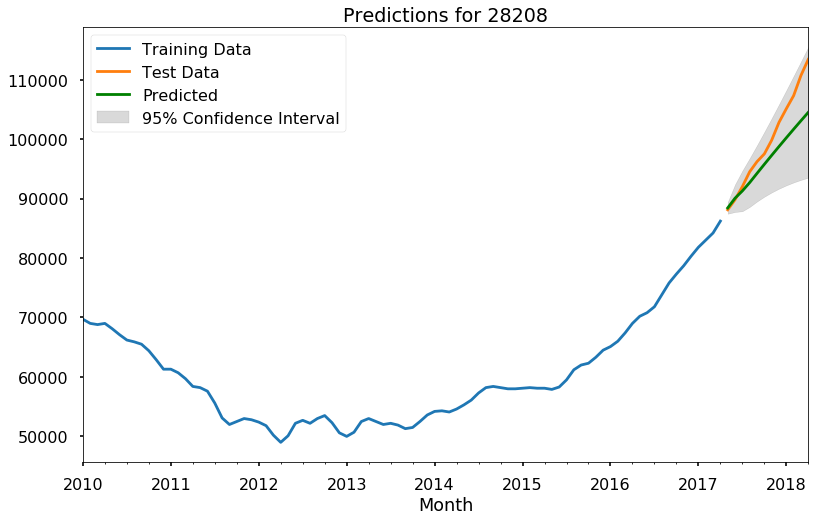

Best PDQ combination: (1, 1, 5)
Predicted ROI: 21.22%
Overall Score: 21.91


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  28208   No. Observations:                   88
Model:               SARIMAX(1, 1, 5)   Log Likelihood                -617.910
Date:                Wed, 15 Jan 2020   AIC                           1249.820
Time:                        11:55:59   BIC                           1266.581
Sample:                    01-01-2010   HQIC                          1256.545
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9869      0.035     28.283      0.000       0.919       1.055
ma.L1          0.1746      0.100      1.752      0.080      -0.021       0.370
ma.L2         -0.7394      0.111     -6.660      0.000      -0.957      -0.522
ma.L3         -0.6324      0.121     -5.228      0.000      -0.870      -0.395
ma.L4          0.3165      0.111      2.860      0.004       0.100       0.533
ma.L5          0.2644      0.102      2.580      0.010       0.064       0.465
sigma2       2.46e+05   4.58e+04      5.373      0.000    1.56e+05    3.36e+05
===================================================================================
Ljung-Box (Q):                       41.33   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.41   Prob(JB):                         0.93
Heteroskedasticity (H):               0.37   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

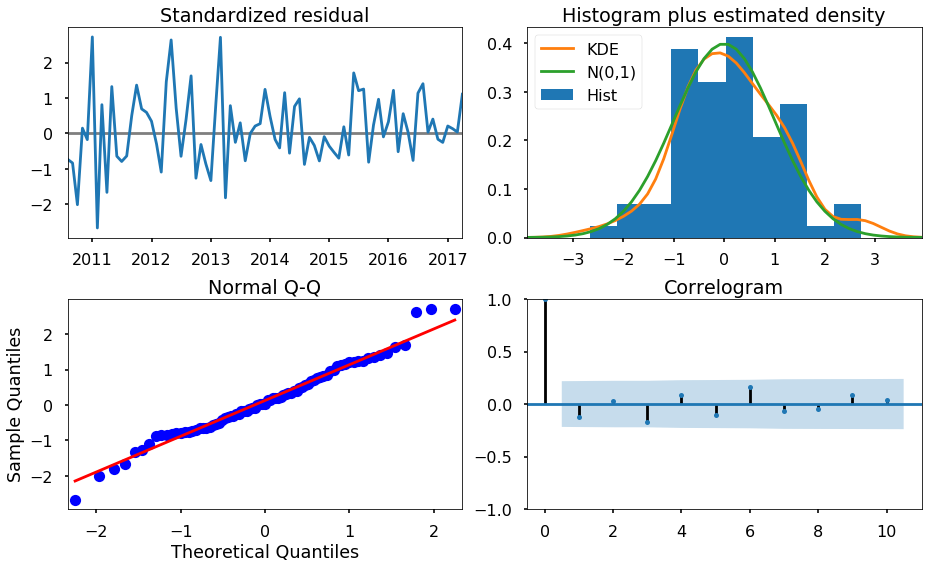

In [32]:
for zipcode in df_exp.sort_values('Score', ascending=False)['Zip'].head(5):
    ts_ = df[df['ZipCode'] == zipcode]['MeanValue'].rename(zipcode)
    ts_ = ts_.resample('MS').asfreq()
    arima_tune(ts_, test_size=0.12, plot=True, show_stats=True)

I don't mind that 4/5 predictions are lower than the test data reveals. We are far enough away from the 2008 crash that I think it's worth taking a more conservative approach, in anticipation of another dip in prices.

# Visualizing Predictions

Our last task is to create visualizations of the predicted data one year after the observed data leaves off. Again, this uses a lot of the same lines of code seen in previous functions, which will be cleaned up and made more efficient in future iterations of this project. 

In [33]:
def prediction_plot(zipcodes, test_size=0.1):
    
    import math
    import itertools
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    import warnings
    warnings.filterwarnings('ignore')
    
    for zipcode in zipcodes:
        ts = df[df['ZipCode'] == zipcode]['MeanValue'].rename(zipcode)
        ts = ts.resample('MS').asfreq()
        
        ts_split = math.floor(len(ts.index) * (1-test_size))

        ts_train = ts.iloc[:ts_split]
        ts_test = ts.iloc[ts_split:]
    
        results = []
        combinations = list(itertools.product(range(6), [1], range(6)))
        for comb in combinations:
            try:
                model = SARIMAX(ts_train, order=comb, 
                                enforce_stationarity=False, 
                                enforce_invertibility=False)
                output = model.fit()
                results.append([comb, output.aic])
            except:
                continue
    
        df_results = pd.DataFrame(results, columns=['pdq', 'AIC'])
        best_pdq = df_results[df_results['AIC'] == df_results['AIC'].min()]['pdq']
    
        model = SARIMAX(ts, order=best_pdq.values[0],
                             enforce_stationarity=False, 
                             enforce_invertibility=True)
        model_fit = model.fit()
    
        prediction = model_fit.get_prediction(start=ts.index[-1], 
                                              end=ts.index.shift(12)[-1], 
                                              dynamic=True)
    
        df_pred = prediction.conf_int()
        df_pred['predicted_mean'] = prediction.predicted_mean
        
        roi = round(((df_pred['predicted_mean'][-1] - ts_test[-1])/ts_test[-1])*100, 2)
        denom = np.log(df_pred[f"upper {ts.name}"][-1] - df_pred[f"upper {ts.name}"][0])
        score = 10 * roi / denom
        
        fig, ax = plt.subplots(figsize=(13,8))
        df_plot = pd.concat([df_pred, pd.DataFrame(ts)], axis=1)
        
        ts.plot(ax=ax,label='Actual Data')
        df_pred['predicted_mean'].plot(ax=ax, label='Predicted', color='g')
        ax.fill_between(df_pred.index, df_pred[f'lower {ts.name}'],
                        df_pred[f'upper {ts.name}'], color="k", alpha=.15,
                        label = '95% Confidence Interval')
        ax.legend()
        ax.set(title=f"1-Year Predictions for {ts.name} (Score: {round(score, 1)})")
        ax.set_xlabel('Year')
        ax.set_ylabel('Price (USD)')
        plt.show()
        

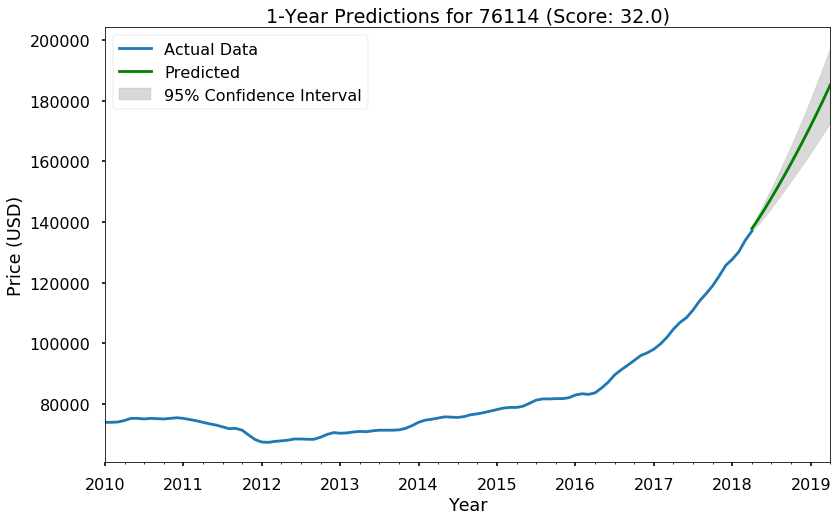

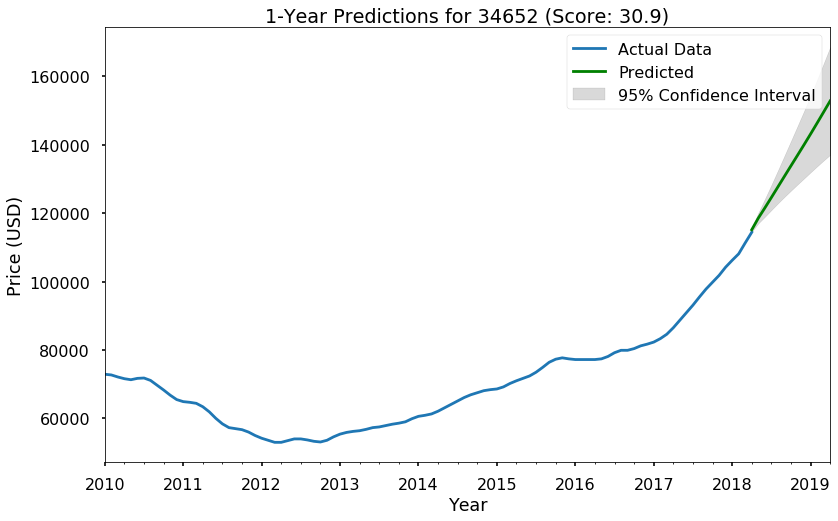

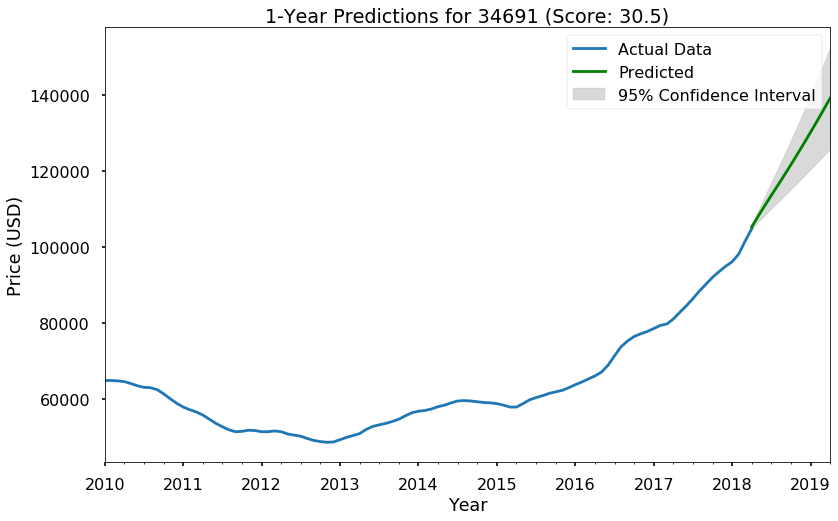

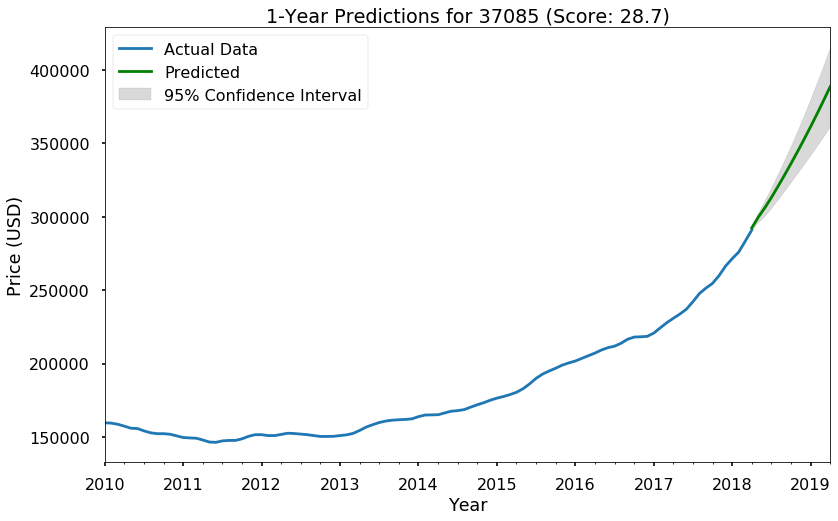

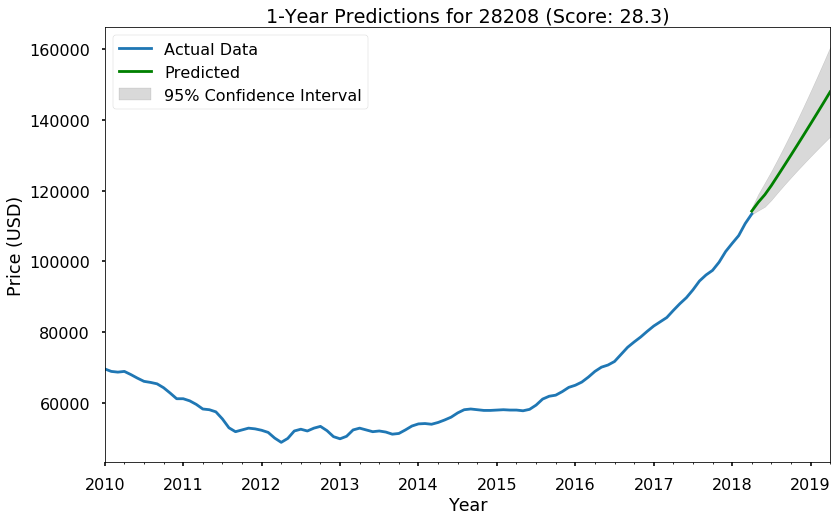

In [34]:
zipcodes = list(df_exp.sort_values('Score', ascending=False)['Zip'].head(5))
prediction_plot(zipcodes)

# Conclusions

So, as described above, the top five ZIP codes are, in order of most worthy to least:
* 76114
* 34652
* 34691
* 37085
* 28208

It's worth noting that five of the top ten ZIP codes are in Dallas-Fort Worth area, and three of the bottom five ZIP codes are in Miami-Fort Lauderdale. Additionally, the only two cities in our dataset to have all positive scores are Las Vegas and Tampa. 